In [1]:
# from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

import spacy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import libs.prepDataVisual as prep

%matplotlib inline

In [2]:
corpus = prep.load_file('data/sentence_phrases.txt').split('\n') #lemma_tokenized_sentences.txt
tokens = [doc.split() for doc in corpus]
max_length = max([len(doc) for doc in tokens]) + 1
print(len(corpus), max_length)

2481 41


In [3]:
%%time
## Documents training LDA, topic Scenarios
## separeting sentences into topics
ldacorpus, keytopics_prob = prep.ldatrain(tokens)#, loading=False)  # create LDA
docid_topic = [(i, topic[0][0]) for i, topic in enumerate(ldacorpus)]

CPU times: user 664 ms, sys: 3.37 ms, total: 668 ms
Wall time: 687 ms


In [4]:
## separates sentences into their topics, stores as index-sentence
docid_topic = np.asarray(docid_topic)
topics = np.unique(docid_topic[:,1])
topic_docs = list()
for i in topics:
    docs = [doc for doc, topic in docid_topic if topic == i]
    topic_docs.append(docs)
print([len(docs) for docs in topic_docs])

[488, 357, 593, 463, 580]


In [5]:
%%time
# get vectors embedding
vectors = prep.doc2vec_model(tokens)#, loading=False)  # create vect

CPU times: user 140 ms, sys: 12.4 ms, total: 152 ms
Wall time: 175 ms


In [6]:
%%time
## convert multi-dimensional vector into 2-dimensional vector

vectors = prep.tsne_transform(vectors)#, loading=False)  # create transformer
# separate vector docs into topics
vectors_topics = list()
for topic in topic_docs:
    vecs = [doc for i, doc in enumerate(vectors) if i in topic]
    vectors_topics.append(vecs)

CPU times: user 749 ms, sys: 0 ns, total: 749 ms
Wall time: 752 ms


In [7]:
## kmeans model
from sklearn.cluster import KMeans

k = 10
km_model = KMeans(n_clusters=k, max_iter=700)

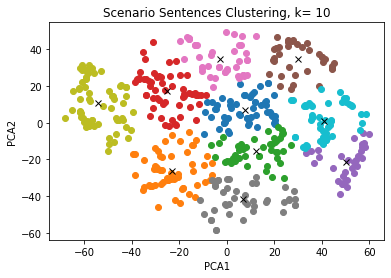

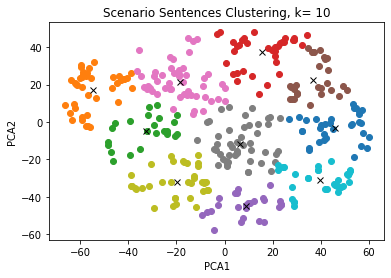

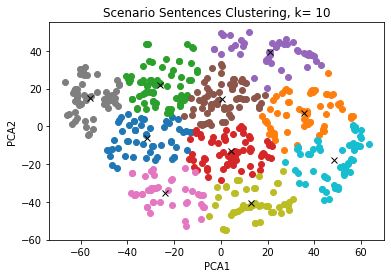

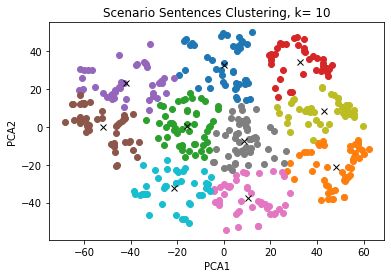

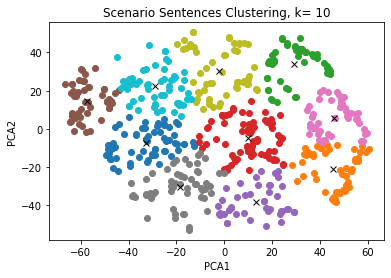

CPU times: user 2.54 s, sys: 61.5 ms, total: 2.6 s
Wall time: 1.67 s


In [8]:
%%time
## run
yhats, topics_centroids = prep.clustering_topics(km_model, vectors_topics, k)#, loading=False)  # create predictor

In [9]:
## combine predicted cluster and documents
## topics, each topic contains clusters, each cluster contains sentences
topics_clusters = list() # list of all clustered docs in topics, got 5 topics, 10 clusters for each

## clustering sentences belong to topics
for i in range(len(yhats)):
    docs = list(zip(topic_docs[i], yhats[i])) 
    docs = np.asarray(docs)
    clusters = np.unique(docs[:, 1])
    topic = list()
    for c in clusters:
        cluster = [ix for ix, e in docs if e == c]
        topic.append(cluster)
        
    topics_clusters.append(topic)

In [10]:
## calculating cluster-center distance, sorted nearest
## contains topics, clusters, nearest sentences ascending order
sorted_topics_clusters = list()
for i in range(len(topics_clusters)):
    topics = list()
    clusters = topics_clusters[i]
    for j in range(len(clusters)):
        cluster = [vec for ix, vec in enumerate(vectors) if ix in clusters[j]]
        dis = prep.index_min_distance(clusters[j], cluster, topics_centroids[i][j])
        topics.append(dis)
    sorted_topics_clusters.append(topics)
    
## job done
del topics_clusters

# assign 

In [11]:
## Assign topic's keywords to clusters
## loading doc2vec model
emb_model = Doc2Vec.load('pickled_data/doc2vecmodel_project.h5')
keytopics = [[key[1] for key in topic] for topic, s in keytopics_prob]
## convert key-topics into vector
keytopics_vectors = [[emb_model.infer_vector([key]) for key in topic] for topic in keytopics]

## convert multi-D vector into 2-D vector
keytopics_vectors = [prep.tsne_transform_only(vec) for vec in keytopics_vectors]
# print(keytopics_vectors)

In [12]:
## computes distance between key-topic and clusters, choose nearest
from sklearn.metrics import pairwise_distances

## key to clusters distance for each topic
closestkeys_clusters = list() # pair key-cluster_index

for i in range(len(keytopics_vectors)):
    topic = keytopics_vectors[i]
    key_clusters = list()
    for j in range(len(topic)):
        distances = pairwise_distances(topics_centroids[i], topic[j].reshape(1, -1), metric='euclidean')
        index = np.arange(len(topics_centroids[i]))
        pairs = sorted(zip(index, distances[:, 0]), key=lambda x: x[1])
        key_clusters.append((keytopics[i][j], pairs))
    closestkeys_clusters.append(key_clusters)

In [13]:
def assigned_key_cluster(keys_clusters):
    ## check key has the same closed clusters
    keyclusters = [[k, c[0]] for k, c in keys_clusters] # pair key-cluster assign, nearest first
    clusters = [c[0] for k, c in keyclusters] # init clusters
    
    ## ck all keys have assigned same cluster, 
    ## if yes, change to the to next, that not in clusters list
    for i in range(len(keyclusters) - 1):
        for j in range(i+1, len(keyclusters)):
            if keyclusters[i][1][0] == keyclusters[j][1][0]:
                if keyclusters[i][1][1] - keyclusters[j][1][1] > 0:
                    pairs = keys_clusters[i][1] # list of (cluster, score)
                    for c in pairs:
                        if c[0] in clusters: # check cluster index in the clusters list
                            continue
                        else:
                            keyclusters[i][1] = c
                            clusters[j] = c[0] # update new number in clusters
                else:
                    pairs = keys_clusters[j][1]
                    for c in pairs: # when j score greater
                        if c[0] in clusters:
                            continue
                        else:
                            keyclusters[j][1] = c
                            clusters[j] = c[0]
    return keyclusters
 
topics_keyclusters = [assigned_key_cluster(topic) for topic in closestkeys_clusters]

In [14]:
## assign key-topic to separated group of sentences (clustering)
topics_keyclusters = [[[k, c[0]] for k, c in topic] for topic in topics_keyclusters]


In [15]:
## contains topics, [topickeys, [clusters_sentences]]
# sorted_topics_clusters

for i in range(len(topics_keyclusters)):
    topic = topics_keyclusters[i]
    for j in range(len(topic)):
        c = topic[j]
        key = c[0]
        cluster = c[1]
        ## implanting key into clustered sentences
        sorted_topics_clusters[i][int(cluster)] = [key, sorted_topics_clusters[i][int(cluster)]]
## ==> final list of [topics, [keys, [clustered sentences' index]]]        

In [16]:
# len(sorted_topics_clusters)

# Visualize corpus

In [17]:
def mapping_clusterlines(topicsclusters, corpus):
    lines = list()
    for i in range(len(topicsclusters)):
        topic = topicsclusters[i]
        for j in range(len(topic)):
            key = topic[j][0]
            cluster = topic[j][1]
            for ix in cluster:
                line = [ix, corpus[ix], i, j, key]
                lines.append(line)
    lines = sorted(lines, key=lambda x: x[0])
    return lines

In [18]:
df = pd.DataFrame(mapping_clusterlines(sorted_topics_clusters, corpus),
                  columns=['id', 'sentences', 'topics', 'clusters', 'clusterkeys'])
df.head(20)

,id,sentences,topics,clusters,clusterkeys
0,1,approach long_term care_insurance reimburse_in...,3,3,measure
1,3,addition care_worker germany receive_bonus,4,0,include
2,10,lack_information advice care people_live dementia,2,1,care
3,20,march_april2020 ban public_assembly place germ...,2,5,pandemic
4,21,apply family_person live_household,3,1,support
5,25,law_alter usual_organisation competence_federa...,2,0,visit
6,30,april2020 rki change advice_recommend wearing_...,3,1,support
7,31,wearing_community mask_recommend situation pro...,3,2,staff
8,37,aim_establish person contact_trace team resident,2,1,care
9,42,april_onwards step_take lift_restriction,0,1,study


# Word Model
Most likely in relationshipe with the inspected word. check for each sentence

In [19]:
# %%time
# ## word model
# multiwords = prep.multiword_model(tokens)#, loading=False)  # create word-model

In [20]:
# ## mapping the sentence's phrases to clusters
# def mapping_phrases(sorted_topics_clusters, line_phrases):
#     topics_phrases = list()
#     for topic in sorted_topics_clusters:
#         topics = list()
#         for k, clusters in topic:
#             phrases = list()
#             for ix in clusters:
#                 phrases.append((ix, line_phrases[ix]))
#             topics.append([k, phrases])
#         topics_phrases.append(topics)
#     return topics_phrases


# topics_phrases = mapping_phrases(sorted_topics_clusters, tokens)
# ## ==> result: [topics [keys, clusters[(phrases)]]]
# # topics_phrases

In [21]:
# ## ranking phrases in clusters, ranking work's importance in sentence 
# def ranking_clusterphrases(model, phrases):
#     rankphrases = list()
#     for topic in phrases:
#         topics = list()
#         for k, clusters in topic:
#             ranks = list()
#             for ix, line in clusters:
#                 #print(line)
#                 if len(line) == 0:
#                     ranks.append((ix, ''))
#                 else:                    
#                     ranks.append((ix, model.wv.rank_by_centrality(line)[0][1]))
#                     #print((ix, model.wv.rank_by_centrality(line)[0][1]))
#             topics.append([k, ranks])
#         rankphrases.append(topics)
#     return rankphrases

In [22]:
# ## Who is the most importance in the sentence? keyword of the sentence
# rankphrases = ranking_clusterphrases(multiwords, topics_phrases)
# rankphrases

In [23]:
# # topics_phrases
# ## highest relationship between keyword and sentences
# def high_support_keycluster(model, topics_clusters, line_phrases):
#     supportedwordtokey = list()
#     for topic in topics_clusters:
#         topics = list()
#         for key, cluster in topic:
#             sims = list()
#             for ix in cluster:
#                 sim = model.wv.most_similar_to_given(key, line_phrases[ix])
#                 sims.append((ix, sim))
#             topics.append([key, sims])
#         supportedwordtokey.append(topics)
#     return supportedwordtokey

# ## Who is the highest support to keyword in the sentences?
# supportedkeys = high_support_keycluster(multiwords, sorted_topics_clusters, tokens)
# supportedkeys

In [24]:
# ## looking for word relationship, syntax: (health - free_of_covid19) + reaction --> attributes
# def pair_word_relations(model, rankphrases, supportedkeys):
#     relations = list()
#     for i in range(len(rankphrases)): # get the topic
#         topic = rankphrases[i]
#         support = supportedkeys[i]
#         keyclusters = list()
#         # iter key and cluster with j
#         for j in range(len(topic)):
#             key = topic[j][0]
#             ranks = topic[j][1]
#             supports = support[j][1]
#             sims = list()
#             for t in range(len(ranks)):
#                 ix = ranks[t][0]
#                 ran = ranks[t][1]
#                 sup = supports[t][1]
#                 sim = model.wv.most_similar([ran, sup], [key], topn=1)
#                 sim = [key[0] for key in sim]
#                 ## add rank-word, support-word
#                 sim.append(ran)
#                 sim.append(sup)
#                 sims.append((ix, sim))
#             keyclusters.append([key, sims])
#         relations.append(keyclusters)
    
#     return relations
    
# ## Who is the highest relationship to the supported word in the sentence?
# relatedtopicwords = pair_word_relations(multiwords, rankphrases, supportedkeys)

In [25]:
## save memory
# del rankphrases
# del supportedkeys

# Word tree relationships in cluster
spacy, graph words hierarchical tree relationships, search for subordinate related words in a sentence in the same cluster

In [26]:
## tracing back the original sentences 
lines = prep.load_file('data/training_sentences.txt').split('\n')

In [27]:
original_keylines = prep.mapping_original_line(sorted_topics_clusters, lines)
#original_keylines

# Lexicon capture

capture word-phrases and their relationships in each sentence, . Include:

+ Word's class (eg. Noun,..), 

+ position (eg. subject or object), 

+ entity recognition (eg. ORG, People,..), 

+ Nearest Neighbors of word (could be a subordination word): How could identify HeatProvider which is the main actor?

In [28]:
nlp = prep.load_spacy()

In [29]:
import re


def check_clause(doc, para, puncts):
    re_subj = re.compile('(\w)subj(\w+)?')
    re_obj = re.compile('(\w)obj')
    #objs = 'dobj pobj nsubj nsubjpass'.split()
    #conjs = 'conj'.split()
    ph = list()
    para = [w for w in para]
    for token in para:
        o = None
        if token.pos_ == 'PRON' or token.pos_ == 'DET' or token.pos_ == 'ADP':
            continue
        elif re_obj.search(token.dep_):
            o = token.dep_            
        elif re_subj.search(token.dep_):
            o = token.dep_
        elif token.dep_ == 'conj':
            o = token.dep_
            if token.lemma_.lower() == 'be':
                o = None
                
        if o != None:
            p = [w for w in doc[token.left_edge.i : token.i+1].text.split() if w.lower() not in puncts]
            ph.append((o, '_'.join(p)))
        
    if len(ph) < 1:
        for token in para:
            o = None
            if token.pos_ == 'PRON' or token.pos_ == 'DET' or token.pos_ == 'ADP':
                continue
            elif token.dep_ == 'attr':
                o = token.dep_
            
            if o != None:
                p = [w for w in doc[token.left_edge.i : token.i+1].text.split() if w.lower() not in puncts]
                ph.append((o, '_'.join(p)))
           
    return ph


def processing_action_stmt(verb_token):
    """ check the main verb for sentence is active (True) or not active (False)"""
    excls = 'xcomp ccomp'.split()
    active = False
    relationship = None
    verb_phrase = [w for w in verb_token.children]
    if verb_token.lemma_.lower() == 'be':  # to be form
        # express the child-parent relationship, if obj is a org, person, group
        relationship = 'is'
    elif verb_token.lemma_.lower() == 'have':  # to have form
        relationship = 'has'
        for token in verb_phrase:
            if token.dep_ in excls:
                if token.lemma_.lower() != 'be':
                    if token.lemma_.lower() != 'have':
                        active = True
                        break            
    else:
        active = True
        relationship = verb_token.lemma_.lower()
        
    return (active, relationship)


## identify action statement, ner with spacy
def lexical_lines(nlp, line):
    """ spacy model, noun_chunks for a line, ner list
        @return: elements in a sentence, subj, verb, predicate
    """
    re_aux = re.compile('aux(\w+)?')
    puncts = 'a an this that those these , . : ; _ the'.split()
    
    doc = nlp(line)
    for token in doc:
        ## search for a main verb in this sentence
        if token.dep_ == 'ROOT':
            start = 0
            active = processing_action_stmt(token)
            subj = check_clause(doc, doc[0 : token.i], puncts)
            pred = check_clause(doc, doc[token.i : doc[-1].i + 1], puncts)
            break
            
    return ([active, subj, pred], [(ent.text, ent.label_) for ent in doc.ents])

In [30]:
## lexicon and Action Statement detection
syntactic_lines = list()
for topic in original_keylines:
    topics = list()
    for key, cluster in topic:
        cat = list()
        for ix, line, _ in cluster:
            cat.append((ix, lexical_lines(nlp, line)))
        topics.append((key, cat))
    syntactic_lines.append(topics)
    
syntactic_lines

[[('health',
   [(113,
     ([(False, 'is'),
       [('pobj', 'care-workers'),
        ('pobj', 'three-year_apprenticeship_minimum_wage')],
       [('pobj', '1-April-2021')]],
      [('three-year', 'DATE'), ('15', 'MONEY')])),
    (1493,
     ([(True, 'has'),
       [('nsubj', 'Cases'), ('pobj', 'ages'), ('pobj', '40-and-59-years')],
       [('dobj', 'longest_interval'),
        ('pobj', 'symptom_onset'),
        ('conj', 'hospitalisation'),
        ('conj', 'if_admitted'),
        ('pobj', 'intensive-care-unit')]],
      [('between the ages of', 'DATE'),
       ('40', 'CARDINAL'),
       ('six-days', 'DATE'),
       ('ICU', 'ORG'),
       ('ICU', 'ORG'),
       ('eleven-days', 'DATE')])),
    (1451,
     ([(True, 'intend'),
       [('nsubjpass', 'Targeted_reforms')],
       [('conj', 'accelerate'),
        ('dobj', 'disbursement'),
        ('pobj', 'public_funding'),
        ('conj', 'supporting'),
        ('conj', 'private'),
        ('dobj', 'both_public_and_private_investment_activ

In [32]:
## separate entities into categories e.g. 'ORG': [(line_ix, entity), ...]
cat_entities = prep.line_entity_categories(syntactic_lines)    

In [33]:
spacy.explain('NORP') #'CARDINAL'

'Nationalities or religious or political groups'

In [34]:
cat_entities.keys()

dict_keys(['DATE', 'MONEY', 'CARDINAL', 'ORG', 'QUANTITY', 'PERCENT', 'ORDINAL', 'NORP', 'LOC', 'TIME', 'GPE', 'PRODUCT', 'LAW', 'WORK_OF_ART', 'EVENT', 'PERSON', 'LANGUAGE', 'FAC'])

# Action Statements

search reason in a sentence, causes of the Subject had behaviors. 

- Reason-Result relationship

- Result-Reason relationship

In [35]:
# process syntactic-lines
action_stmts = list()
for topic in syntactic_lines:
    #topics = list()
    for key, cluster in topic:
        #cat = list()
        for ix, line in cluster:
            line = line[0]
            #if line[0][0]:
            action_stmts.append((ix, line))

action_stmts

[(113,
  [(False, 'is'),
   [('pobj', 'care-workers'),
    ('pobj', 'three-year_apprenticeship_minimum_wage')],
   [('pobj', '1-April-2021')]]),
 (1493,
  [(True, 'has'),
   [('nsubj', 'Cases'), ('pobj', 'ages'), ('pobj', '40-and-59-years')],
   [('dobj', 'longest_interval'),
    ('pobj', 'symptom_onset'),
    ('conj', 'hospitalisation'),
    ('conj', 'if_admitted'),
    ('pobj', 'intensive-care-unit')]]),
 (1451,
  [(True, 'intend'),
   [('nsubjpass', 'Targeted_reforms')],
   [('conj', 'accelerate'),
    ('dobj', 'disbursement'),
    ('pobj', 'public_funding'),
    ('conj', 'supporting'),
    ('conj', 'private'),
    ('dobj', 'both_public_and_private_investment_activities'),
    ('pobj', 'meaningful_way')]]),
 (1548,
  [(True, 'decrease'),
   [('pobj', 'contrast'),
    ('nsubj', 'percentage'),
    ('pobj', 'cases'),
    ('pobj', '40-to-59-year-olds'),
    ('pobj', 'reporting')],
   [('pobj', 'reporting'),
    ('nsubj', 'week-20'),
    ('conj', 'by_reporting_week-20_had_stabilised'),
 

In [36]:
def load_trace_numbers():
    trace = prep.load_file('data/tracing.txt')
    trace = trace.split('\n')
    trace = [line.split() for line in trace]
    trace = [[int(w) for w in line if w.isnumeric()] for line in trace]
    
    return trace


def tracing_original_line(line_id, traces):
    """ trace the processed sentence back to an original sentence"""
    ix = 0
    for doc in traces:
        n = line_id + doc[0]
        if n - doc[2] <= 0:
            if n >= doc[1]:
                ix = line_id + doc[0] # trace back to original 
                break
        else:
            ix = None
    return ix

traces = load_trace_numbers()

In [37]:
%%time
## new model of doc2vec, Based on word-relationship, similarity of sentences to the word of sentence
## calc word-relationship with BOW
tokens = prep.load_file('data/lemmanized_sentences.txt').split('\n')
tokens = [line.split() for line in tokens]
print(len(tokens))

2481
CPU times: user 5.16 ms, sys: 44 µs, total: 5.2 ms
Wall time: 5.61 ms


In [38]:
# sorted_topics_clusters

# Conceptual Analysis

- Apply Concept-Relationship Rules 

- Classify Entities-Relatives for Action-Statements with the Relation Rules

In [39]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

## create Tf-idf model
def create_tfidf_model(corpus):
    """ Provide tf-idf vector model for future using"""
    model = TfidfVectorizer().fit(corpus)
    
    return model

## raw string-based corpus
corpus = [' '.join(line) for line in tokens]
tfidf_model = create_tfidf_model(corpus)

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 75.7 ms


In [40]:
## create tf-idf vectors of very sentence in the tokens
tfidf_vectors = [tfidf_model.transform(line) for line in tokens]

In [41]:
%%time


## searching related sentences contain the relevant word-phrase of the topic inner a cluster.
def search_phraseInLine(model, phrase, cluster, vector_lines, tracing):
    """ """
    key2vec = model.transform(phrase)
    cat = list()
    for ix in cluster:
        line2vec = vector_lines[ix]
        dnc = pairwise_distances(key2vec, line2vec, metric='euclidean')
        dnc = np.sum(dnc)/len(dnc.reshape(-1, 1))
        cat.append((ix, dnc))
    cat = sorted(cat, key=lambda i: i[1])
    cat = [line[0] for line in cat]
    if len(cat) > 10:
        cat = cat[:10]
    cat = [tracing_original_line(line, tracing) for line in cat]
    
    return cat    


# sorted_topics_clusters
## searching for the topic-key in sentences of a cluster
def key_in_line(topic_corpus, actions):
    key_inLine = list()
    for topic in topic_corpus:
        topics = list()
        for key, cluster in topic:
            top = key.split('_')
            cat = search_phraseInLine(tfidf_model, top, cluster, tfidf_vectors, traces)
            rlt = [(ix, stm) for ix, stm in actions if ix in cat]
            topics.append((key, rlt))
        key_inLine.append(topics)
    return key_inLine

key_inLine = key_in_line(sorted_topics_clusters, action_stmts)
key_inLine

CPU times: user 635 ms, sys: 3.9 ms, total: 639 ms
Wall time: 638 ms


[[('health',
   [(1451,
     [(True, 'intend'),
      [('nsubjpass', 'Targeted_reforms')],
      [('conj', 'accelerate'),
       ('dobj', 'disbursement'),
       ('pobj', 'public_funding'),
       ('conj', 'supporting'),
       ('conj', 'private'),
       ('dobj', 'both_public_and_private_investment_activities'),
       ('pobj', 'meaningful_way')]]),
    (1550,
     [(False, 'is'),
      [('nsubj', 'both_median'), ('conj', 'mean_value')],
      [('attr', '50-years')]]),
    (196,
     [(True, 'train'),
      [('nsubj', 'Staff'),
       ('csubjpass', 'Staff_supporting'),
       ('dobj', 'residents'),
       ('conj', 'confirmed'),
       ('pobj', 'suspected_and_confirmed-cases')],
      [('conj', 'not_be_asked'), ('pobj', 'others')]]),
    (143,
     [(False, 'has'),
      [],
      [('pobj', 'medical_assessment'),
       ('pobj', 'continued_ambulatory_support'),
       ('pobj', 'isolation'),
       ('pobj', 'care-home'),
       ('conj', 'requirement'),
       ('nsubj', 'environment'),
 

# 1. setup Relation Rules (Entities-Relatives)

In [42]:
def relation_rules(clause):
    re_subj = re.compile('(\w)subj(\w+)?')
    ## search for relatives
    dobjs = list()
    entity = ''
    for con, phrase in clause:
        if re_subj.search(con):
            if con == 'nsubj':
                if entity != '':
                    dobjs.append(('ins', entity))
                    entity = phrase
                else:
                    entity = phrase
            elif con == 'csubjpass' or con == 'csubj':
                entity = phrase
            elif con == 'nsubjpass':
                if entity == '':
                    entity = phrase
                else:
                    dobjs.append(('ins', phrase))
        elif con == 'dobj':
            dobjs.append(('ins', phrase))
        else:
            dobjs.append(('rel', phrase))
    if entity != '':
        return [entity, dobjs]
    else:
        return dobjs
                    
def entities_relatives(line):
    ix = line[0]
    rel = line[1][0]
    subj = line[1][1]
    obj = line[1][2]
    subjs = relation_rules(subj)
    objs = relation_rules(obj)
    return (ix, rel, subjs, objs)

In [43]:
%%time
conceptuals = list()
for topic in key_inLine:
    topics = list()
    for key, cluster in topic:
        cat = list()
        for line in cluster:
            #display(line)
            cat.append(entities_relatives(line))
        topics.append((key, cat))
    conceptuals.append(topics)

conceptuals

CPU times: user 5.33 ms, sys: 46 µs, total: 5.37 ms
Wall time: 5.35 ms


[[('health',
   [(1451,
     (True, 'intend'),
     ['Targeted_reforms', []],
     [('rel', 'accelerate'),
      ('ins', 'disbursement'),
      ('rel', 'public_funding'),
      ('rel', 'supporting'),
      ('rel', 'private'),
      ('ins', 'both_public_and_private_investment_activities'),
      ('rel', 'meaningful_way')]),
    (1550,
     (False, 'is'),
     ['both_median', [('rel', 'mean_value')]],
     [('rel', '50-years')]),
    (196,
     (True, 'train'),
     ['Staff_supporting',
      [('ins', 'residents'),
       ('rel', 'confirmed'),
       ('rel', 'suspected_and_confirmed-cases')]],
     [('rel', 'not_be_asked'), ('rel', 'others')]),
    (143,
     (False, 'has'),
     [],
     ['environment',
      [('rel', 'medical_assessment'),
       ('rel', 'continued_ambulatory_support'),
       ('rel', 'isolation'),
       ('rel', 'care-home'),
       ('rel', 'requirement'),
       ('ins', 'patient')]]),
    (2239,
     (True, 'describe'),
     ['Individual_publications', []],
     [('i

# 2. Conceptual Relationships

- Sentence is an action statement

- Sentence must have an subject


In [44]:
# search annotations for each entity of the concept
def words_model(tokens, epochs = 100, filename='pickled_data/words_model.h5', loading=True):
    """"""
    if loading:
        emb_model = Doc2Vec.load(filename)
    else:
        max_length = max([len(line) for line in tokens]) + 1
        win_size = max_length//2
        tagdocs = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]
        emb_model = Doc2Vec(tagdocs, 
                            window=win_size,
                            alpha=1e3,
                            min_count=1, 
                            vector_size=max_length,
                            dbow_words=0,
                            dm_concat=0,
                            workers=3,
                            dm=0, #DBOW
                            hs=1,                            
                            epochs=epochs)
        
        emb_model.save(filename)
    return emb_model
    
word_model = words_model(tokens)#, loading=False)

In [45]:
def search_annotations(phrase, model, tracing):
    """search most similarity meaning sentence to phrase"""
    phrase = prep.clean_text(phrase, nlp)
    vector =   model.infer_vector(phrase)
    sim = model.dv.most_similar(vector, topn=2)
    sim = [tracing_original_line(ix[0], tracing) for ix in sim] #id
    return sim

In [46]:
def set_entity_annotations(clause, actions):
    entity = None
    relations = list()
    if len(clause) > 0:
        for sub in clause:
            if isinstance(sub, str):
                ann = search_annotations(sub, word_model, traces)
                
                entity = (sub, ann)
            elif isinstance(sub, list):
                if len(sub) > 0:
                    ins = list()
                    rel = list()
                    for con, phrase in sub:
                        ann = search_annotations(phrase, word_model, traces)
                        if con == 'ins':
                            ins.append((phrase, ann))
                        else:
                            rel.append((phrase, ann))
                    relations = ins + rel
    if entity != None:
        return [entity, relations]
    else:
        return relations
    

def conceptual_relationships(line):
    """"""
    ix, act, subj, obj = line
    if act[0]: # true
        ## defines the conceptual for sentence
        if len(subj) > 0:
            pass
            
    else: #false
        pass